<!-- NAVIGATION -->
< [Chapter 14. Adventures in Covariance](14-adventures-in-covariance.html) | [Chapter 16. Generalized Linear Madness](16-generalized-linear-madness.html) >

<div class="admonition note">
          <span style="white-space: nowrap;">
            <a href="https://colab.research.google.com/github/fehiepsi/rethinking-numpyro/blob/master/notebooks/15_missing_data_and_other_opportunities.ipynb">
              <img alt="Open In Colab"
                src="https://colab.research.google.com/assets/colab-badge.svg"
                style="vertical-align:text-bottom">
            </a>
          </span>
        </div>

In [ ]:
!pip install -q numpyro arviz causalgraphicalmodels daft

In [0]:
import math
import os

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import jax.numpy as jnp
from jax import ops, random, vmap
from jax.scipy.special import expit

import numpyro
import numpyro.distributions as dist
from numpyro.diagnostics import print_summary
from numpyro.distributions import constraints
from numpyro.infer import MCMC, NUTS, init_to_value

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
az.style.use("arviz-darkgrid")
numpyro.set_platform("cpu")
numpyro.set_host_device_count(4)

### Code 15.1

In [1]:
# simulate a pancake and return randomly ordered sides
def sim_pancake(seed):
    pancake = dist.Categorical(logits=jnp.ones(3)).sample(random.PRNGKey(2 * seed))
    sides = jnp.array([1, 1, 1, 0, 0, 0]).reshape(3, 2).T[:, pancake]
    return random.permutation(random.PRNGKey(2 * seed + 1), sides)


# sim 10,000 pancakes
pancakes = vmap(sim_pancake, out_axes=1)(jnp.arange(10000))
up = pancakes[0]
down = pancakes[1]

# compute proportion 1/1 (BB) out of all 1/1 and 1/0
num_11_10 = jnp.sum(up == 1)
num_11 = jnp.sum((up == 1) & (down == 1))
num_11 / num_11_10

DeviceArray(0.6641716, dtype=float32)

### Code 15.2

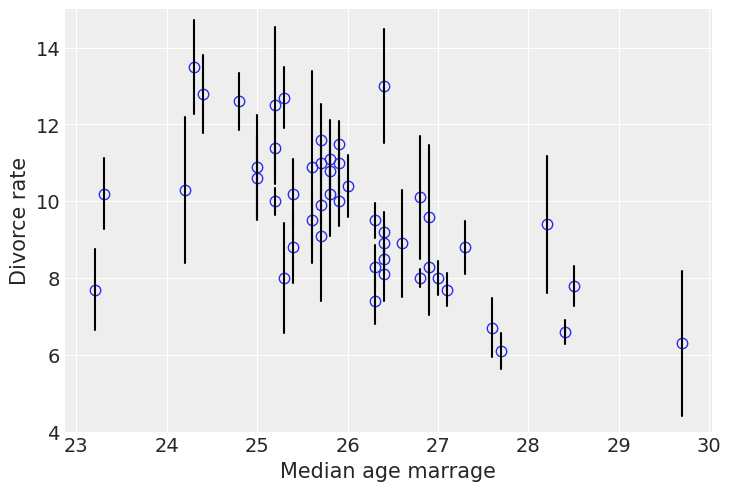

In [2]:
WaffleDivorce = pd.read_csv("../data/WaffleDivorce.csv", sep=";")
d = WaffleDivorce

# points
ax = az.plot_pair(
    d[["MedianAgeMarriage", "Divorce"]].to_dict(orient="list"),
    scatter_kwargs=dict(ms=15, mfc="none"),
)
ax.set(ylim=(4, 15), xlabel="Median age marrage", ylabel="Divorce rate")

# standard errors
for i in range(d.shape[0]):
    ci = d.Divorce[i] + jnp.array([-1, 1]) * d["Divorce SE"][i]
    x = d.MedianAgeMarriage[i]
    plt.plot([x, x], ci, "k")

### Code 15.3

In [3]:
dlist = dict(
    D_obs=d.Divorce.pipe(lambda x: (x - x.mean()) / x.std()).values,
    D_sd=d["Divorce SE"].values / d.Divorce.std(),
    M=d.Marriage.pipe(lambda x: (x - x.mean()) / x.std()).values,
    A=d.MedianAgeMarriage.pipe(lambda x: (x - x.mean()) / x.std()).values,
    N=d.shape[0],
)


def model(A, M, D_sd, D_obs, N):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bA = numpyro.sample("bA", dist.Normal(0, 0.5))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + bA * A + bM * M
    D_true = numpyro.sample("D_true", dist.Normal(mu, sigma))
    numpyro.sample("D_obs", dist.Normal(D_true, D_sd), obs=D_obs)


m15_1 = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=4)
m15_1.run(random.PRNGKey(0), **dlist)

### Code 15.4

In [4]:
m15_1.print_summary(0.89)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
 D_true[0]      1.18      0.37      1.18      0.63      1.82   2994.08      1.00
 D_true[1]      0.68      0.56      0.68     -0.15      1.63   3886.40      1.00
 D_true[2]      0.43      0.35      0.43     -0.10      1.02   3496.83      1.00
 D_true[3]      1.41      0.47      1.42      0.65      2.11   3191.36      1.00
 D_true[4]     -0.90      0.13     -0.90     -1.10     -0.69   4891.79      1.00
 D_true[5]      0.65      0.38      0.66      0.07      1.29   3366.77      1.00
 D_true[6]     -1.37      0.35     -1.37     -1.94     -0.85   3792.56      1.00
 D_true[7]     -0.35      0.49     -0.33     -1.10      0.44   3352.11      1.00
 D_true[8]     -1.88      0.60     -1.89     -2.82     -0.90   2520.68      1.00
 D_true[9]     -0.62      0.16     -0.62     -0.85     -0.32   3877.20      1.00
D_true[10]      0.78      0.28      0.77      0.35      1.22   4248.21      1.00
D_true[11]     -0.56      0

### Code 15.5

In [5]:
dlist = dict(
    D_obs=d.Divorce.pipe(lambda x: (x - x.mean()) / x.std()).values,
    D_sd=d["Divorce SE"].values / d.Divorce.std(),
    M_obs=d.Marriage.pipe(lambda x: (x - x.mean()) / x.std()).values,
    M_sd=d["Marriage SE"].values / d.Marriage.std(),
    A=d.MedianAgeMarriage.pipe(lambda x: (x - x.mean()) / x.std()).values,
    N=d.shape[0],
)


def model(A, M_sd, M_obs, D_sd, D_obs, N):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bA = numpyro.sample("bA", dist.Normal(0, 0.5))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    M_est = numpyro.sample("M_est", dist.Normal(0, 1).expand([N]))
    numpyro.sample("M_obs", dist.Normal(M_est, M_sd), obs=M_obs)
    mu = a + bA * A + bM * M_est
    D_est = numpyro.sample("D_est", dist.Normal(mu, sigma))
    numpyro.sample("D_obs", dist.Normal(D_est, D_sd), obs=D_obs)


m15_2 = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=4)
m15_2.run(random.PRNGKey(0), **dlist)

### Code 15.6

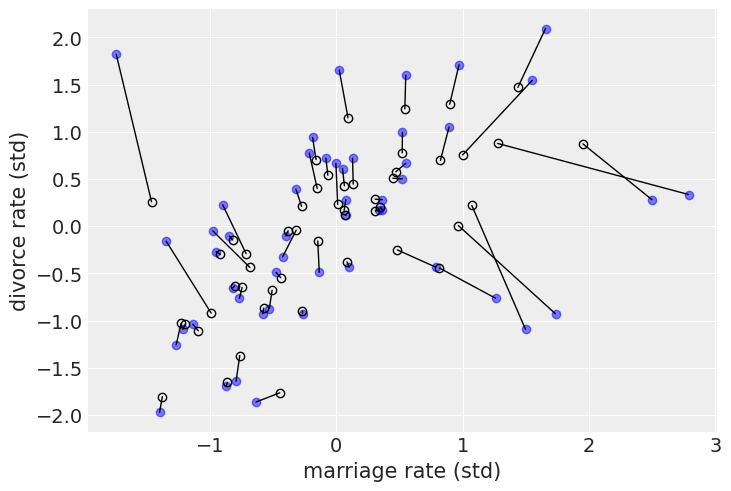

In [6]:
post = m15_2.get_samples()
D_est = jnp.mean(post["D_est"], 0)
M_est = jnp.mean(post["M_est"], 0)
plt.plot(dlist["M_obs"], dlist["D_obs"], "bo", alpha=0.5)
plt.gca().set(xlabel="marriage rate (std)", ylabel="divorce rate (std)")
plt.plot(M_est, D_est, "ko", mfc="none")
for i in range(d.shape[0]):
    plt.plot([dlist["M_obs"][i], M_est[i]], [dlist["D_obs"][i], D_est[i]], "k-", lw=1)

### Code 15.7

In [7]:
N = 500
A = dist.Normal().sample(random.PRNGKey(0), (N,))
M = dist.Normal(-A).sample(random.PRNGKey(1))
D = dist.Normal(A).sample(random.PRNGKey(2))
A_obs = dist.Normal(A).sample(random.PRNGKey(3))

### Code 15.8

In [8]:
N = 100
S = dist.Normal().sample(random.PRNGKey(0), (N,))
H = dist.Binomial(10, expit(S)).sample(random.PRNGKey(1))

### Code 15.9

In [9]:
D = dist.Bernoulli(0.5).sample(random.PRNGKey(2), (N,))  # dogs completely random
Hm = jnp.where(D == 1, jnp.nan, H)

### Code 15.10

In [10]:
D = jnp.where(S > 0, 1, 0)
Hm = jnp.where(D == 1, jnp.nan, H)

### Code 15.11

In [11]:
with numpyro.handlers.seed(rng_seed=501):
    N = 1000
    X = numpyro.sample("X", dist.Normal().expand([N]))
    S = numpyro.sample("S", dist.Normal().expand([N]))
    H = numpyro.sample("H", dist.Binomial(10, logits=2 + S - 2 * X))
    D = jnp.where(X > 1, 1, 0)
    Hm = jnp.where(D == 1, jnp.nan, H)

### Code 15.12

In [12]:
dat_list = dict(H=H, S=S)


def model(S, H):
    a = numpyro.sample("a", dist.Normal(0, 1))
    bS = numpyro.sample("bS", dist.Normal(0, 0.5))
    logit_p = a + bS * S
    numpyro.sample("H", dist.Binomial(10, logits=logit_p), obs=H)


m15_3 = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=4)
m15_3.run(random.PRNGKey(0), **dat_list)
m15_3.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      1.32      0.03      1.32      1.28      1.36   1473.87      1.00
        bS      0.62      0.03      0.62      0.58      0.66   1294.44      1.00

Number of divergences: 0


### Code 15.13

In [13]:
dat_list0 = dict(H=H[D == 0], S=S[D == 0])


def model(S, H):
    a = numpyro.sample("a", dist.Normal(0, 1))
    bS = numpyro.sample("bS", dist.Normal(0, 0.5))
    logit_p = a + bS * S
    numpyro.sample("H", dist.Binomial(10, logits=logit_p), obs=H)


m15_4 = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=4)
m15_4.run(random.PRNGKey(0), **dat_list0)
m15_4.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      1.92      0.03      1.92      1.86      1.97   1027.57      1.01
        bS      0.72      0.03      0.72      0.67      0.78   1039.30      1.00

Number of divergences: 0


### Code 15.14

In [14]:
D = jnp.where(jnp.abs(X) < 1, 1, 0)

### Code 15.15

In [15]:
N = 100
S = dist.Normal().sample(random.PRNGKey(0), (N,))
H = dist.Binomial(10, logits=S).sample(random.PRNGKey(1))
D = jnp.where(H < 5, 1, 0)
Hm = jnp.where(D == 1, jnp.nan, H)

### Code 15.16

In [16]:
milk = pd.read_csv("../data/milk.csv", sep=";")
d = milk
d["neocortex.prop"] = d["neocortex.perc"] / 100
d["logmass"] = d.mass.apply(math.log)

### Code 15.17

In [17]:
dat_list = dict(
    K=d["kcal.per.g"].pipe(lambda x: (x - x.mean()) / x.std()).values,
    B=d["neocortex.prop"].pipe(lambda x: (x - x.mean()) / x.std()).values,
    M=d.logmass.pipe(lambda x: (x - x.mean()) / x.std()).values,
)


def model(B, M, K):
    a = numpyro.sample("a", dist.Normal(0, 0.5))
    nu = numpyro.sample("nu", dist.Normal(0, 0.5))
    bB = numpyro.sample("bB", dist.Normal(0, 0.5))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    sigma_B = numpyro.sample("sigma_B", dist.Exponential(1))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    B_impute = numpyro.sample(
        "B_impute", dist.Normal(0, 1).expand([int(np.isnan(B).sum())]).mask(False)
    )
    B = ops.index_update(B, np.nonzero(np.isnan(B))[0], B_impute)
    numpyro.sample("B", dist.Normal(nu, sigma_B), obs=B)
    mu = a + bB * B + bM * M
    numpyro.sample("K", dist.Normal(mu, sigma), obs=K)


m15_5 = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=4)
m15_5.run(random.PRNGKey(0), **dat_list)

### Code 15.18

In [18]:
m15_5.print_summary(0.89)


                  mean       std    median      5.5%     94.5%     n_eff     r_hat
 B_impute[0]     -0.59      0.93     -0.61     -2.06      0.86   1655.83      1.00
 B_impute[1]     -0.72      0.94     -0.73     -2.31      0.72   1612.19      1.00
 B_impute[2]     -0.74      0.93     -0.76     -2.18      0.83   1767.06      1.00
 B_impute[3]     -0.31      0.89     -0.33     -1.68      1.14   2108.70      1.00
 B_impute[4]      0.45      0.90      0.44     -0.88      1.91   2078.89      1.00
 B_impute[5]     -0.18      0.93     -0.19     -1.67      1.21   2398.70      1.00
 B_impute[6]      0.18      0.89      0.19     -1.24      1.60   2515.01      1.00
 B_impute[7]      0.30      0.87      0.30     -1.03      1.69   2381.34      1.00
 B_impute[8]      0.51      0.89      0.53     -0.94      1.82   2092.03      1.00
 B_impute[9]     -0.44      0.92     -0.44     -1.94      0.94   1808.37      1.00
B_impute[10]     -0.26      0.89     -0.28     -1.62      1.19   2006.01      1.00
B_i

### Code 15.19

In [19]:
obs_idx = d["neocortex.prop"].notnull().values
dat_list_obs = dict(
    K=dat_list["K"][obs_idx], B=dat_list["B"][obs_idx], M=dat_list["M"][obs_idx]
)


def model(B, M, K):
    a = numpyro.sample("a", dist.Normal(0, 0.5))
    nu = numpyro.sample("nu", dist.Normal(0, 0.5))
    bB = numpyro.sample("bB", dist.Normal(0, 0.5))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    sigma_B = numpyro.sample("sigma_B", dist.Exponential(1))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    numpyro.sample("B", dist.Normal(nu, sigma_B), obs=B)
    mu = a + bB * B + bM * M
    numpyro.sample("K", dist.Normal(mu, sigma), obs=K)


m15_6 = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=4)
m15_6.run(random.PRNGKey(0), **dat_list_obs)
m15_6.print_summary(0.89)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      0.10      0.19      0.10     -0.19      0.43   2099.18      1.00
        bB      0.61      0.28      0.62      0.15      1.02   1260.84      1.00
        bM     -0.64      0.25     -0.65     -1.05     -0.27   1227.34      1.00
        nu     -0.01      0.23      0.00     -0.35      0.37   2052.60      1.00
     sigma      0.87      0.19      0.83      0.60      1.13   1141.14      1.00
   sigma_B      1.05      0.19      1.03      0.74      1.31   1891.93      1.00

Number of divergences: 0


### Code 15.20

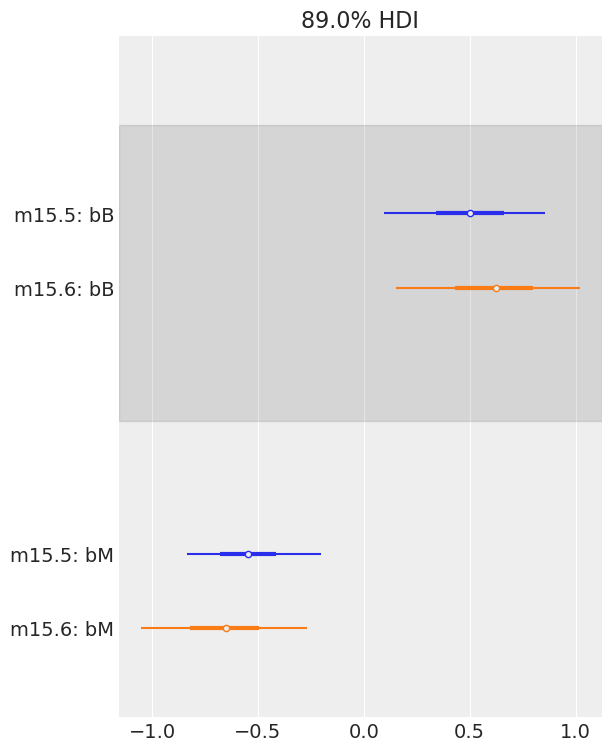

In [20]:
az.plot_forest(
    [az.from_numpyro(m15_5), az.from_numpyro(m15_6)],
    model_names=["m15.5", "m15.6"],
    var_names=["bB", "bM"],
    combined=True,
    hdi_prob=0.89,
)
plt.show()

### Code 15.21

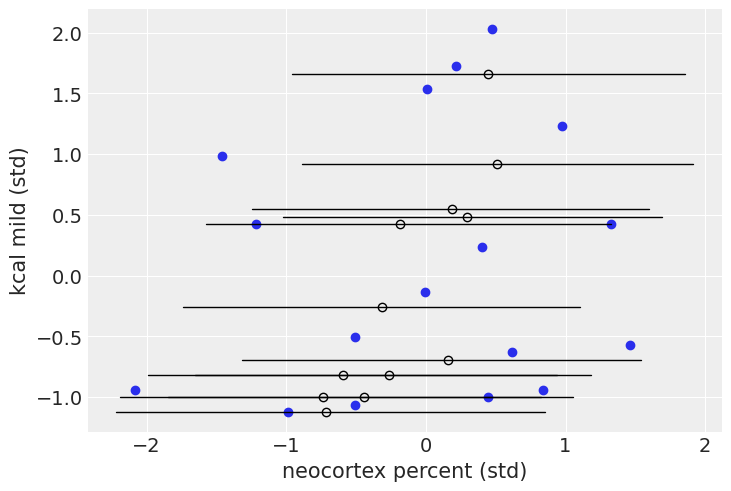

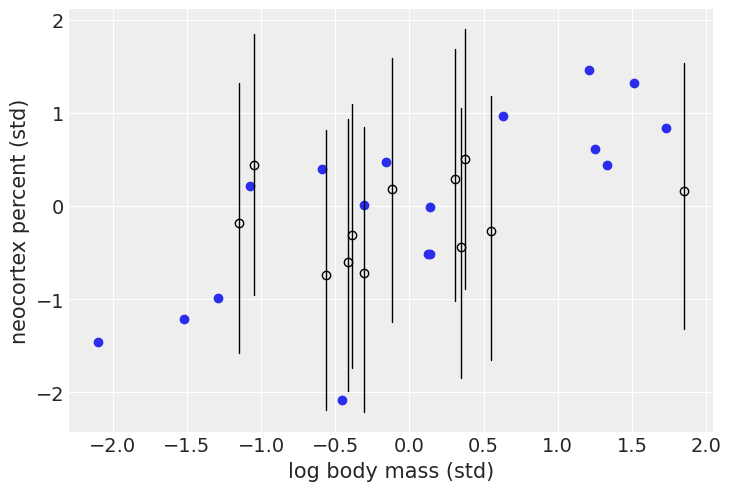

In [21]:
post = m15_5.get_samples()
B_impute_mu = jnp.mean(post["B_impute"], 0)
B_impute_ci = jnp.percentile(post["B_impute"], q=jnp.array([5.5, 94.5]), axis=0)

# B vs K
plt.plot(dat_list["B"], dat_list["K"], "o")
plt.gca().set(xlabel="neocortex percent (std)", ylabel="kcal mild (std)")
miss_idx = pd.isna(dat_list["B"]).nonzero()[0]
Ki = dat_list["K"][miss_idx]
plt.plot(B_impute_mu, Ki, "ko", mfc="none")
for i in range(12):
    plt.plot(B_impute_ci[:, i], jnp.repeat(Ki[i], 2), "k", lw=1)
plt.show()

# M vs B
plt.plot(dat_list["M"], dat_list["B"], "o")
plt.gca().set(xlabel="log body mass (std)", ylabel="neocortex percent (std)")
Mi = dat_list["M"][miss_idx]
plt.plot(Mi, B_impute_mu, "ko", mfc="none")
for i in range(12):
    plt.plot(jnp.repeat(Mi[i], 2), B_impute_ci[:, i], "k", lw=1)

### Code 15.22

In [22]:
def model(B, M, K):
    # priors
    a = numpyro.sample("a", dist.Normal(0, 0.5))
    muB = numpyro.sample("muB", dist.Normal(0, 0.5))
    muM = numpyro.sample("muM", dist.Normal(0, 0.5))
    bB = numpyro.sample("bB", dist.Normal(0, 0.5))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    Rho_BM = numpyro.sample("Rho_BM", dist.LKJ(2, 2))
    Sigma_BM = numpyro.sample("Sigma_BM", dist.Exponential(1).expand([2]))

    # define B_merge as mix of observed and imputed values
    B_impute = numpyro.sample(
        "B_impute", dist.Normal(0, 1).expand([int(np.isnan(B).sum())]).mask(False)
    )
    B_merge = ops.index_update(B, np.nonzero(np.isnan(B))[0], B_impute)

    # M and B correlation
    MB = jnp.stack([M, B_merge], axis=1)
    cov = jnp.outer(Sigma_BM, Sigma_BM) * Rho_BM
    numpyro.sample("MB", dist.MultivariateNormal(jnp.stack([muM, muB]), cov), obs=MB)

    # K as function of B and M
    mu = a + bB * B_merge + bM * M
    numpyro.sample("K", dist.Normal(mu, sigma), obs=K)


m15_7 = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=4)
m15_7.run(random.PRNGKey(0), **dat_list)
post = m15_7.get_samples(group_by_chain=True)
print_summary({k: v for k, v in post.items() if k in ["bM", "bB", "Rho_BM"]})


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
Rho_BM[0,0]      1.00      0.00      1.00      1.00      1.00       nan       nan
Rho_BM[0,1]      0.60      0.14      0.62      0.39      0.80   1416.93      1.00
Rho_BM[1,0]      0.60      0.14      0.62      0.39      0.80   1416.93      1.00
Rho_BM[1,1]      1.00      0.00      1.00      1.00      1.00   1718.78      1.00
         bB      0.58      0.26      0.59      0.14      0.98    704.15      1.01
         bM     -0.64      0.23     -0.64     -1.02     -0.30    942.12      1.00



### Code 15.23

In [23]:
B_missidx = pd.isna(dat_list["B"]).nonzero()[0]

### Code 15.24

In [24]:
Moralizing_gods = pd.read_csv("../data/Moralizing_gods.csv", sep=";")
Moralizing_gods

,polity,year,population,moralizing_gods,writing
0,Big Island Hawaii,1000,3.729643,NaN,0
1,Big Island Hawaii,1100,3.729643,NaN,0
2,Big Island Hawaii,1200,3.598340,NaN,0
3,Big Island Hawaii,1300,4.026240,NaN,0
4,Big Island Hawaii,1400,4.311767,NaN,0
...,...,...,...,...,...
859,Yemeni Coastal Plain,1400,6.763083,1.0,1
860,Yemeni Coastal Plain,1500,6.519621,1.0,1
861,Konya Plain,1600,7.447158,1.0,1
862,Yemeni Coastal Plain,1700,3.882606,1.0,1


### Code 15.25

In [25]:
Moralizing_gods.moralizing_gods.value_counts(dropna=False)

NaN    528
1.0    319
0.0     17
Name: moralizing_gods, dtype: int64

### Code 15.26

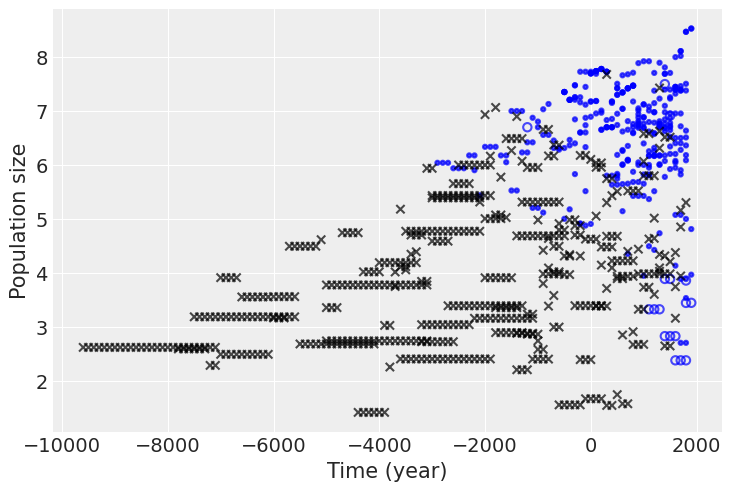

In [26]:
symbol = Moralizing_gods.moralizing_gods.apply(lambda x: "." if x == 1 else "o")
symbol[Moralizing_gods.moralizing_gods.isna()] = "x"
color = Moralizing_gods.moralizing_gods.apply(lambda x: "k" if pd.isna(x) else "b")
for pch in ["o", ".", "x"]:
    plt.scatter(
        Moralizing_gods.year[symbol == pch],
        Moralizing_gods.population[symbol == pch],
        marker=pch,
        color=color[symbol == pch],
        facecolor="none" if pch == "o" else None,
        lw=1.5,
        alpha=0.7,
    )
plt.gca().set(xlabel="Time (year)", ylabel="Population size")
plt.show()

### Code 15.27

In [27]:
dmg = Moralizing_gods
dmg.astype(str).groupby(["moralizing_gods", "writing"]).size().unstack(fill_value=0)

writing,0,1
moralizing_gods,,
0.0,16,1
1.0,9,310
nan,442,86


### Code 15.28

In [28]:
dmg = Moralizing_gods
haw = dmg.polity == "Big Island Hawaii"
dmg.loc[haw, ["year", "population", "writing", "moralizing_gods"]].T.round(3)

,0,1,2,3,4,5,6,7,8
year,1000.00,1100.00,1200.000,1300.000,1400.000,1500.000,1600.000,1700.000,1800.000
population,3.73,3.73,3.598,4.026,4.312,4.205,4.374,5.158,4.997
writing,0.00,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000
moralizing_gods,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000


### Code 15.29

In [29]:
with numpyro.handlers.seed(rng_seed=9):
    N_houses = 100
    alpha = 5
    beta = -3
    k = 0.5
    r = 0.2
    cat = numpyro.sample("cat", dist.Bernoulli(k).expand([N_houses]))
    notes = numpyro.sample("notes", dist.Poisson(alpha + beta * cat))
    R_C = numpyro.sample("R_C", dist.Bernoulli(r).expand([N_houses]))
    cat_obs = jnp.where(R_C == 1, -9, cat)

### Code 15.30

In [30]:
dat = dict(notes=notes, cat=cat_obs.copy(), RC=R_C.copy(), N=N_houses - 1)


def model(N, RC, cat, notes):
    # priors
    a = numpyro.sample("a", dist.Normal(0, 1))
    b = numpyro.sample("b", dist.Normal(0, 0.5))

    # sneaking cat model
    k = numpyro.sample("k", dist.Beta(2, 2))
    numpyro.sample("cat|RC==0", dist.Bernoulli(k), obs=cat[RC == 0])

    # singing bird model
    # cat NA:
    custom_logprob = jnp.logaddexp(
        jnp.log(k) + dist.Poisson(jnp.exp(a + b)).log_prob(notes[RC == 1]),
        jnp.log(1 - k) + dist.Poisson(jnp.exp(a)).log_prob(notes[RC == 1]),
    )
    numpyro.factor("notes|RC==1", custom_logprob)
    # cat known present/absent:
    lambda_ = jnp.exp(a + b * cat[RC == 0])
    numpyro.sample("notes|RC==0", dist.Poisson(lambda_), obs=notes[RC == 0])


m15_8 = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=4)
m15_8.run(random.PRNGKey(0), **dat)

### Code 15.31

In [31]:
def model(N, RC, cat, notes, link=False):
    a = numpyro.sample("a", dist.Normal(0, 1))
    b = numpyro.sample("b", dist.Normal(0, 0.5))

    # sneaking cat model
    k = numpyro.sample("k", dist.Beta(2, 2))
    numpyro.sample("cat|RC==0", dist.Bernoulli(k), obs=cat[RC == 0])

    # singing bird model
    custom_logprob = jnp.logaddexp(
        jnp.log(k) + dist.Poisson(jnp.exp(a + b)).log_prob(notes[RC == 1]),
        jnp.log(1 - k) + dist.Poisson(jnp.exp(a)).log_prob(notes[RC == 1]),
    )
    numpyro.factor("notes|RC==1", custom_logprob)
    lambda_ = jnp.exp(a + b * cat[RC == 0])
    numpyro.sample("notes|RC==0", dist.Poisson(lambda_), obs=notes[RC == 0])

    if link:
        lpC0 = numpyro.deterministic(
            "lpC0", jnp.log(1 - k) + dist.Poisson(jnp.exp(a)).log_prob(notes)
        )
        lpC1 = numpyro.deterministic(
            "lpC1", jnp.log(k) + dist.Poisson(jnp.exp(a + b)).log_prob(notes)
        )
        numpyro.deterministic("PrC1", jnp.exp(lpC1) / (jnp.exp(lpC1) + jnp.exp(lpC0)))


m15_9 = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=4)
m15_9.run(random.PRNGKey(0), **dat)

### Code 15.32

In [32]:
with numpyro.handlers.seed(rng_seed=100):
    x = numpyro.sample("x", dist.Normal().expand([10]))
    y = numpyro.sample("y", dist.Normal(x))
    x = jnp.concatenate([x, jnp.array([jnp.nan])])
    y = jnp.concatenate([y, jnp.array([100])])
    d = dict(x=x, y=y)

### Code 15.33

In [33]:
Primates301 = pd.read_csv("../data/Primates301.csv", sep=";")
d = Primates301
cc = d.dropna(subset=["brain", "body"]).index
B = d.brain[cc]
M = d.body[cc]
B = B.values / max(B)
M = M.values / max(M)

### Code 15.34

In [34]:
Bse = B * 0.1
Mse = M * 0.1

### Code 15.35

In [35]:
dat_list = dict(B=B, M=M)


def model(M, B):
    a = numpyro.sample("a", dist.Normal(0, 1))
    b = numpyro.sample("b", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + b * jnp.log(M)
    numpyro.sample("B", dist.LogNormal(mu, sigma), obs=B)


m15H4 = MCMC(NUTS(model), num_warmup=500, num_samples=500)
m15H4.run(random.PRNGKey(0), **dat_list)

sample: 100%|██████████| 1000/1000 [00:06<00:00, 158.50it/s, 7 steps of size 2.37e-01. acc. prob=0.95]


### Code 15.36

In [36]:
start = dict(M_true=dat_list["M"], B_true=dat_list["B"])
init_strategy = init_to_value(values=start)

### Code 15.37

In [37]:
Primates301 = pd.read_csv("../data/Primates301.csv", sep=";")
d = Primates301
d.isna().sum()

name                     0
genus                    0
species                  0
subspecies             267
spp_id                   0
genus_id                 0
social_learning         98
research_effort        115
brain                  117
body                    63
group_size             114
gestation              161
weaning                185
longevity              181
sex_maturity           194
maternal_investment    197
dtype: int64

### Code 15.38

In [38]:
cc = d.dropna(subset=["body"]).index
M = d.body[cc]
M = M.values / max(M)
B = d.brain[cc]
B = B.values / B.max(skipna=True)

### Code 15.39

In [39]:
start = dict(B_impute=jnp.repeat(0.5, 56))
init_strategy = init_to_value(values=start)

<!-- NAVIGATION -->
< [Chapter 14. Adventures in Covariance](14-adventures-in-covariance.html) | [Chapter 16. Generalized Linear Madness](16-generalized-linear-madness.html) >